In [1]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 定義 PCA 與隨後的邏輯斯迴歸函數
logistic = SGDClassifier(loss='log', penalty='l2', max_iter=10000, tol=1e-5, random_state=0)#SGDClassifier梯度下降分類方法
#penalty 可以通過懲罰參數設置具體懲罰。 SGD支持以下處罰：
#loss 具體的損失函數可以通過損耗參數設置。 SGDRegressor支持以下丟失功能：
#max_iter 訓練數據（也稱為紀元）的最大傳球次數
#tol ： float或None，可選（默認值= 1e-3）停止標準。 如果它不是None，則迭代將在n_iter_no_change連續時期（loss> best_loss - tol）時停止。
#andom_state ： int，RandomState實例或None，可選（默認=無）
#偽隨機數生成器的種子，用於在混洗數據時使用。 如果是int，則random_state是隨機數生成器使用的種子; 如果是RandomState實例，則random_state是隨機數生成器; 如果為None，則隨機數生成器是np.random使用的RandomState實例。
pca = PCA() #主成分分析
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)]) #使用最終估算器進行變換的流水線。


# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [3]:
# 先執行 GridSearchCV 跑出最佳參數
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64], #components 組件的意思
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)
#cv：int，交叉驗證生成器或可迭代的，可選的
'''
lid
如果為True，則返回折疊的平均分數，並按每個測試集中的樣本數加權。 在這種情況下，假設數據在折疊中相同地分佈，並且最小化的損失是每個樣本的總損失，而不是折疊的平均損失。 如果為False，則返回折疊的平均分數。 默認值為True，但在版本0.22中將更改為False，以對應於交叉驗證的標准定義。

版本0.20更改：默認情況下，版本0.22中的參數iid將從True更改為False，並將在0.24中刪除。


return_train_score：boolean，default = False
如果為False，則cv_results_屬性將不包括訓練分數。 計算訓練分數用於深入了解不同參數設置如何影響過度擬合/欠擬合權衡。 然而，計算訓練集上的分數可能在計算上是昂貴的，並且不是嚴格要求選擇產生最佳泛化性能的參數。
'''
#GridSearchCV實現了“適合”和“得分”方法。 如果它們在所使用的估計器中實現，它還實現“
# param_grid 字典或字典列表
search.fit(X_digits, y_digits)#對數據集進行分析擬合
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.918):
{'logistic__alpha': 1.0, 'pca__n_components': 30}


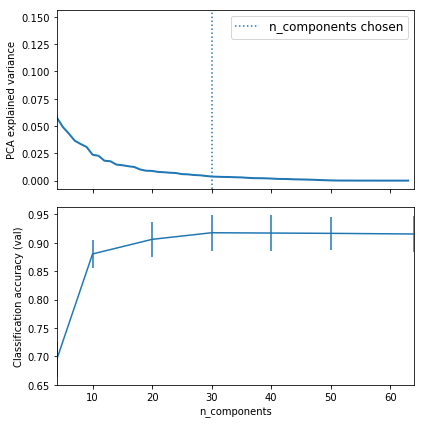

In [12]:
# 繪製不同 components 的 PCA 解釋度
pca.fit(X_digits) #fit(X) 表示用数据X来训练PCA模型。
'''
主成分分析（Principal Component Analysis，PCA）是一種比較常見的數據分析方法，主要運用於數據降維，是通過線性變換將原來數據（N維數據）轉換成線性無關的維度來表示，轉換後的維度是根據方差大小排列，因此通過提取前K維（K≤N）數據，從而實現原數據的維度的下降。該方法儘可能保存了原有數據的差異性。

'''

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))#fig 是畫圖
#plt.subplots 是一种简便的创建图表的办法，他会创建一个新的 Figure，并返回一个数组
#sharex=True表示共享x轴坐标
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
#plot() 函数可以用来绘图：
#explained_variance_ratio 參數返回每個維度解釋的方差的向量
ax0.set_ylabel('PCA explained variance')#设置y轴的文字

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
#search.best_estimator_.named_steps 意思是搜尋最好的值命名的
#n_components：要保留組件的數量
#axvline(2) #画一条y = 2的垂直线
#linestyle用於指明線型 : 點綴
#label='n_components chosen' 圖例的文字
ax0.legend(prop=dict(size=12)) #圖例的大小
#legend 图例
# 繪製不同採樣點的分類正確率

results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
#components 組件
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))
#nlargest()分组取最大多行并求和
#results.groupby 結果分組 .apply 應用
#lambda 定义了一个匿名函数 max = lambda m, n: m if m > n else n print(max(10, 3))  # 顯示 10
#差異是由於參數iid。如果設置爲False，則mean_test_score是通過摺疊的平均值計算的。mean 平均的得分

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
#圖例 legend
#std 標準的得分
#plot() 函数可以用来绘图：
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout() #plt.tight_layout()表示紧凑显示图像
plt.show()